In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
%matplotlib inline
products = pd.read_csv('data/amazon_baby_subset.csv')
important_words = pd.read_json('data/important_words.json')[0]

In [103]:
def remove_punctuation(text):
    import string
    # first parameter should be translate table
    return text.translate(str.maketrans('', '', string.punctuation))


def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = np.concatenate((['constant'], features))
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)


def predict_probability(feature_matrix, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1+np.exp(-scores))
    return predictions


def predict_sentiment(feature_matrix, coefficients):
    return (np.dot(feature_matrix, coefficients)>=0)*2-1


def feature_derivative(errors: np.ndarray, feature: np.ndarray):
    derivative = (errors*feature).sum()
    return derivative


def feature_derivative_l2(errors: np.ndarray, feature: np.ndarray, coefficients, l2_penalty, feature_is_constant):
    if feature_is_constant:
        return (errors*feature).sum()
    derivative = (errors*feature).sum()-2*l2_penalty*coefficients
    return derivative


def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==1)
    scores = np.dot(feature_matrix, coefficients)
    ll = ((indicator-1)*scores-np.log(1.+np.exp(-scores))).sum()
    return ll


def compute_log_likelihood_l2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==1)
    scores = np.dot(feature_matrix, coefficients)
    ll = ((indicator-1)*scores-np.log(1.+np.exp(-scores))).sum() -l2_penalty*np.sum(coefficients[1:]**2)
    return ll


def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients)
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_1,w)
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==1)
        errors = indicator - predictions
        
#         print learning situation
        for j in range(len(coefficients)):
            derivative = feature_derivative(errors, feature_matrix[:,j])
            coefficients[j] += step_size*derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients


def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients)
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_1,w)
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==1)
        errors = indicator - predictions
        
        for j in range(len(coefficients)):
            if j==0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_l2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, feature_is_constant)
            coefficients[j] += step_size*derivative

        # print log likelihood of learning
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_l2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    print(l2_penalty)
    return coefficients
    

def score_to_lebel(score: np.ndarray):
    return score > 0


def score_to_probability(score: np.ndarray):
    return 1/(1+np.exp(-score))


def accur(y, y_predict):
    true_pre = (y == y_predict).sum()
    total = len(y)
    return true_pre/total

In [3]:
products = products.fillna({'review':''})
products['review_clean'] = products['review'].apply(remove_punctuation)
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s:s.split().count(word))


In [4]:
(products['perfect']>=1).sum()

2955

In [5]:
feature_matrix, sentiment = get_numpy_data(products, important_words, 'sentiment')
feature_matrix.shape

(53072, 194)

In [6]:
initial_coefficient = np.zeros(194)
step_size = 1e-7
max_iter = 301
coefficients = logistic_regression(feature_matrix, sentiment, initial_coefficient, step_size, max_iter)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

In [19]:
(np.dot(feature_matrix, coefficients)>=0).sum()

25126

In [25]:
ps = predict_sentiment(feature_matrix, coefficients)
accur(products['sentiment'], ps)

0.7518653904130238

In [37]:
c = list(coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, c)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
print('TOP 10: ',word_coefficient_tuples[:10])
print('\nLast 10: ',word_coefficient_tuples[-10:])

TOP 10:  [('great', 0.06654608417045768), ('love', 0.06589076292212326), ('easy', 0.0647945868025784), ('little', 0.04543562630842137), ('loves', 0.04497640139490604), ('well', 0.030135001092107077), ('perfect', 0.029739937104968462), ('old', 0.020077541034775385), ('nice', 0.018408707995268992), ('daughter', 0.017703199905701694)]

Last 10:  [('monitor', -0.02448210054589172), ('return', -0.026592778462247283), ('back', -0.027742697230661334), ('get', -0.028711552980192585), ('disappointed', -0.028978976142317068), ('even', -0.030051249236035808), ('work', -0.03306951529475273), ('money', -0.038982037286487116), ('product', -0.04151103339210889), ('would', -0.05386014844520313)]


## Here starts logistic regression with L2 regularization:

In [49]:
train_data = pd.read_json('data/module-4-assignment-train-idx.json')[0]
validation_data = pd.read_json('data/module-4-assignment-validation-idx.json')[0]

feature_matrix_train, sentiment_train = get_numpy_data(products.loc[train_data,:], important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(products.loc[validation_data,:], important_words, 'sentiment') 

In [104]:
initial_coefficient = np.zeros(194)
step_size = 5e-6
max_iter = 501
l2_penalty = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficient, step_size, l2_penalty, max_iter)
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficient, step_size, 4, max_iter)
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficient, step_size, 10, max_iter)
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficient, step_size, 1e2, max_iter)
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficient, step_size, 1e3, max_iter)
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficient, step_size, 1e5, max_iter)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.42422295
iteration  15: log likelihood of observed labels = -27379.97375625
iteration  20: log likelihood of observed labels = -27027.18208317
iteration  30: log likelihood of observed labels = -26527.22737267
iteration  40: log likelihood of observed labels = -26206.59048765
iteration  50: log likelihood of observed labels = -25995.96903148
iteration  60: log likelihood of observed labels = -25854.95710284
iteration  70: log likelihood of observed labels = -25759.0810

In [105]:
c = coefficients_0_penalty[1:]

coef_word_tuple = list(zip(c, important_words))
coef_word_tuple = sorted(coef_word_tuple, key=lambda x:x[0], reverse=True)
print("TOP5: ",coef_word_tuple[:5])
print("\nLast5: ",coef_word_tuple[-5:])

TOP5:  [(1.0585539820695435, 'love'), (1.0524840477983537, 'loves'), (0.9845588198731924, 'easy'), (0.8356932076383464, 'perfect'), (0.8016249897781763, 'great')]

Last5:  [(-0.5727070451581127, 'returned'), (-0.6178091779812257, 'waste'), (-0.7420849546350395, 'return'), (-0.7687931346121051, 'money'), (-0.9554366281707273, 'disappointed')]


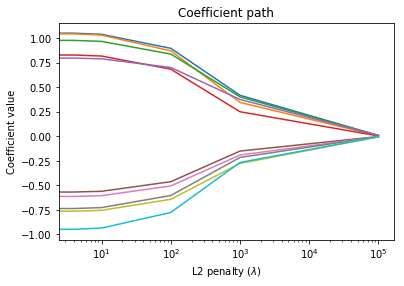

In [119]:
def find_word_idx(word):
    return important_words[important_words == word].index[0]+1

coefs = [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty,
        coefficients_1e3_penalty, coefficients_1e5_penalty]
penaltys = [0,4,10,1e2,1e3,1e5]
ten_words = ['love','loves','easy','perfect','great','returned','waste','return','money','disappointed']

coef_penalty = pd.DataFrame()
for word in ten_words:
    idx = find_word_idx(word)
    coef_penalty[word] = [c[idx] for c in coefs]

import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
for word in ten_words:

    ax.plot(penaltys, coef_penalty[word])
    plt.xscale('log')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.title('Coefficient path')

In [117]:
for i in range(len(coefs)):
    p = predict_sentiment(feature_matrix_train, coefs[i])
    a = accur(sentiment_train, p)
    print('Accuracy of penalty ',penaltys[i],'is: ',a)

Accuracy of penalty  0 is:  0.7851561577866434
Accuracy of penalty  4 is:  0.7851089445480512
Accuracy of penalty  10 is:  0.7849909114515711
Accuracy of penalty  100.0 is:  0.7839758268218409
Accuracy of penalty  1000.0 is:  0.7758551497839994
Accuracy of penalty  100000.0 is:  0.6803663747314747


In [118]:
for i in range(len(coefs)):
    p = predict_sentiment(feature_matrix_valid, coefs[i])
    a = accur(sentiment_valid, p)
    print('Accuracy of penalty ',penaltys[i],'is: ',a)

Accuracy of penalty  0 is:  0.781439641490057
Accuracy of penalty  4 is:  0.7815330034543927
Accuracy of penalty  10 is:  0.7817197273830642
Accuracy of penalty  100.0 is:  0.781066193632714
Accuracy of penalty  1000.0 is:  0.7713565493417982
Accuracy of penalty  100000.0 is:  0.667818130893474


In [127]:
(4.19-4.22)/2

-0.01499999999999968

In [134]:
4.19-1

3.1900000000000004

## Notes:

pd.Series 與 list 操作不同: ['constant']+features